![book](https://raw.githubusercontent.com/ageron/tensorflow-safari-course/master/images/intro_to_tf_course.png)

**Try not to peek at the solutions when you go through the exercises. ;-)**

First let's make sure this notebook works well in both Python 2 and Python 3:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
tf.__version__

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.7.0'

# Linear Regression with TensorFlow

## Loading the training data

In [3]:
import numpy as np

data = np.loadtxt("data/life_satisfaction.csv",
                  dtype=np.float32,
                  delimiter=",",
                  skiprows=1,
                  usecols=[1, 2])
X_train = data[:, 0:1] / 10000 # feature scaling
y_train = data[:, 1:2]

Each row in `X_train` represents a training instance, in this case a country. In this simple regression example, there is just one feature per instance (i.e., one column), in this case the country's GDP per capita (in tens of thousands of dollars).

In [4]:
X_train
print(X_train.shape)

(29, 1)


In [5]:
y_train

array([[6. ],
       [5.6],
       [4.9],
       [5.8],
       [6.1],
       [5.6],
       [4.8],
       [5.1],
       [5.7],
       [6.5],
       [5.8],
       [6. ],
       [5.9],
       [7.4],
       [7.3],
       [6.5],
       [6.9],
       [7. ],
       [7.4],
       [7.3],
       [7.3],
       [6.9],
       [6.8],
       [7.2],
       [7.5],
       [7.3],
       [7. ],
       [7.5],
       [7.2]], dtype=float32)

## Plot the data

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

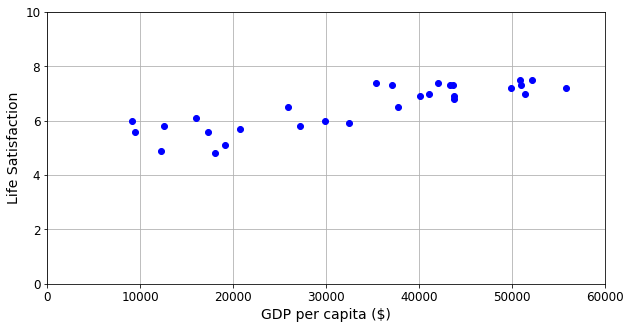

In [7]:
def plot_life_satisfaction(X_train, y_train):
    plt.plot(X_train * 10000, y_train, "bo")
    plt.axis([0, 60000, 0, 10])
    plt.xlabel("GDP per capita ($)")
    plt.ylabel("Life Satisfaction")
    plt.grid()

plt.figure(figsize=(10,5))
plot_life_satisfaction(X_train, y_train)
plt.show()

## Building the Linear Regression Model

## Exercise 4

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

In this exercise we will build a linear regression model using TensorFlow. If you are not familiar with the maths behind linear regression models, you can read the explanation below. If you already know this (or if you don't care much about the maths), you can just skip this explanation and simply follow the instructions given in questions 4.1 to 4.3 below.

In a linear regression model, the predictions are a linear combination of the input features. In other words, the predicted value $\hat{y}$ can be computed using the following equation:

$\hat{y} = w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b$

where:
* $x_1, x_2, \dots, x_n $ are the input features,
* $w_1, w_2, \dots, w_n $, are their corresponding weights,
* and $b$ is the bias term (also called the intercept term).

This equation can be expressed in a more compact way using vectors:

$\hat{y} = \langle \mathbf{x}, \mathbf{w} \rangle + b$

where:
* $ \mathbf{x} = \begin{pmatrix}x_1 \\ x_2 \\ \vdots \\ x_n \end{pmatrix}$ is the input feature vector (by convention, vectors are written in bold font),
* $ \mathbf{w} = \begin{pmatrix}w_1 \\ w_2 \\ \vdots \\ w_n \end{pmatrix}$ is the weight vector,
* $\langle \mathbf{x}, \mathbf{w} \rangle$ is the inner product of vectors $\mathbf{x}$ and $\mathbf{w}$, equal to $w_1 x_1 + w_2 x_2 + \dots + w_n x_n$.

It is often more convenient to handle vectors as matrices with a single column (a "column vector"). The inner product $\langle \mathbf{x}, \mathbf{w} \rangle$ is then replaced with the matrix dot product: $\mathbf{x}^T \cdot \mathbf{w}$, where $\mathbf{x}^T$ is the transpose of the column vector $\mathbf{x}$. Transposing a column vector gives you a "row vector" (i.e., a matrix with a single row): $\mathbf{x}^T = \begin{pmatrix} x_1 & x_2 & \dots & x_n \end{pmatrix}$. Once again $\mathbf{x}^T \cdot \mathbf{w} = w_1 x_1 + w_2 x_2 + \dots + w_n x_n$.

Lastly, it is possible to compute predictions for many instances at a time by putting all their input features in a matrix $\mathbf{X}$ (by convention, matrices are in capital letters with a bold font, except when they just represent column or row vectors). The vector containing the predictions for every instance can be computed using the following equation:

$\hat{\mathbf{y}} = \mathbf{X} \cdot \mathbf{w} + b$

where:
* $ \hat{\mathbf{y}} = \begin{pmatrix}\hat{y}^{(1)} \\ \hat{y}^{(2)} \\ \vdots \\ \hat{y}^{(m)} \end{pmatrix}$ is the prediction vector, containing the predictions for all $m$ instances.
* $ \mathbf{X} = \begin{pmatrix}x_1^{(1)} & x_2^{(1)} & \cdots & x_n^{(1)} \\
                                x_1^{(2)} & x_2^{(2)} & \cdots & x_n^{(2)} \\
                                \vdots    & \vdots    & \ddots & \vdots    \\
                                x_1^{(m)} & x_2^{(m)} & \cdots & x_n^{(m)}\end{pmatrix} =                  \begin{pmatrix}(\mathbf{x}^{(1)})^T \\
                                (\mathbf{x}^{(2)})^T  \\
                                \vdots \\
                                (\mathbf{x}^{(m)})^T\end{pmatrix} $ is the input feature matrix. It contains the input features of all instances for which you want to make predictions. Each row represents an instance, each column represents a feature.
* Note that the matrix dot product $\mathbf{X} \cdot \mathbf{w}$ returns a column vector, so when we add the bias term $b$, we mean adding that value to each and every element in the column vector (this is called _broadcasting_).

4.1) Create a graph containing:
* a constant `X` initialized with `X_train`, which contains the input features of the training instances. In this particular example, there is just a single feature per instance (i.e., the GDP per capita).
* a constant `y` initialized with `y_train`, which contains the labels of each instance (i.e., the life satisfaction).
* a variable `b`, representing the bias term (initialized to 0.0).
* a variable `w`, representing the weight vector (initialized to a column vector full of zeros, using `tf.zeros()`). Since there is just one input feature per instance in this example, this column vector contains a single row (it is a matrix with a single item).
* an operation `y_pred` that computes the equation presented above: $\hat{\mathbf{y}} = \mathbf{X} \cdot \mathbf{w} + b$. You will need to use `tf.matmul()`.
* as always, don't forget to add an `init` operation, using `tf.global_variables_initializer()`.

In [8]:
graph = tf.Graph()
with graph.as_default():
    X = tf.constant(X_train, name="X")
    y = tf.constant(y_train, name="y")

    b = tf.Variable(0.0, name="b")
    w = tf.Variable(tf.zeros([1, 1]), name="w")
    y_pred = tf.add(tf.matmul(X, w), b, name="y_pred")  # X @ w + b
    
    init = tf.global_variables_initializer()

4.2) Start a session, run the `init` operation and evaluate the predictions `y_pred`. Since both variables `b` and `w` are initialized with zeros, you should get a vector full of zeros.

In [9]:
with tf.Session(graph=graph) as sess:
    init.run()
    print(y_pred.eval())

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


4.3) Let's measure how bad the model is using a cost function (also called a loss function). In regression tasks, it is common to use the Mean Square Error (MSE) as the cost function. It is given by the following equation:

$\text{MSE}(\mathbf{w}, b) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{(\hat{y}^{(i)}-y^{(i)})^2}$.

Add an `mse` operation to your graph, to compute the Mean Square Error. Hint: use `tf.reduce_mean()` and `tf.square()`.

In [10]:
with graph.as_default():
    error = y_pred - y
    square_error = tf.square(error)
    mse = tf.reduce_mean(square_error, name="mse")

4.4) Now start a session, initalize the variables and evaluate the MSE. As you can see, the result is quite high: this makes sense since we have not trained the model yet.

In [11]:
with tf.Session(graph=graph) as sess:
    init.run()
    print(mse.eval())   

42.841034


4.5) To find the optimal values for the model parameters (i.e., the variables `w` and `b`), we will use Gradient Descent. For this, we first need to compute the gradient of the cost function with regards to the model parameters.

The gradient of the MSE with regards to the weight vector $\mathbf{w}$ is:

$\nabla_{\mathbf{w}}\, \text{MSE}(\mathbf{w}, b) =
\begin{pmatrix}
 \frac{\partial}{\partial w_0} \text{MSE}(\mathbf{w}, b) \\
 \frac{\partial}{\partial w_1} \text{MSE}(\mathbf{w}, b) \\
 \vdots \\
 \frac{\partial}{\partial w_n} \text{MSE}(\mathbf{w}, b)
\end{pmatrix}
 = \dfrac{2}{m} \mathbf{X}^T \cdot (\hat{\mathbf{y}} - \mathbf{y})
$

And the partial derivative with regards to the bias $b$ is:

$
\dfrac{\partial}{\partial b} \text{MSE}(\mathbf{w}, b) = \dfrac{2}{m} \sum\limits_{i=1}^{m}(\hat{y}^{(i)}-y^{(i)})
$

Add the operations `gradients_w` and `gradients_b` to your graph, using the equations above.

In [12]:
with graph.as_default():
    m = len(X_train)
    gradients_w = 2/m * tf.matmul(tf.transpose(X), error)
    gradients_b = 2 * tf.reduce_mean(error)

4.6) To perform a Gradient Descent step, we need to subtract the gradients (multiplied by the learning rate $\eta$) from the weight vector and the bias:

$
\mathbf{w} \gets \mathbf{w} - \eta \nabla_{\mathbf{w}}\, \text{MSE}(\mathbf{w}, b)
$

$
\mathbf{b} \gets \mathbf{b} - \eta \dfrac{\partial}{\partial b} \text{MSE}(\mathbf{w}, b)
$

Add two assignment operations, `tweak_w_ops` and `tweak_b_ops` that perform the assigments above, using a small learning rate $\eta = 0.01$.

In [13]:
learning_rate = 0.01

with graph.as_default():
    tweak_w_op = tf.assign(w, w - learning_rate * gradients_w)
    tweak_b_op = tf.assign(b, b - learning_rate * gradients_b)
    training_op = tf.group(tweak_w_op, tweak_b_op)

4.7) That's it! We're ready to train the model. Start a session, initialize the variables, then write a loop that will repeatedly evaluate the assignment operations (e.g., 2000 times). Every 100 iterations, evaluate the MSE and print it out. Within a few hundred iterations the MSE should drop below 1.0, and eventually reach about 0.18. Congratulations! You built and trained your first Machine Learning model using TensorFlow!

In [14]:
n_iterations = 2000

with tf.Session(graph=graph) as sess:
    init.run()
    for iteration in range(n_iterations):
        if iteration % 100 == 0:
            print("Iteration {:5}, MSE: {:.4f}".format(iteration, mse.eval()))
        training_op.run()
    w_val, b_val = sess.run([w, b])

Iteration     0, MSE: 42.8410
Iteration   100, MSE: 1.8935
Iteration   200, MSE: 1.1304
Iteration   300, MSE: 0.7073
Iteration   400, MSE: 0.4727
Iteration   500, MSE: 0.3426
Iteration   600, MSE: 0.2705
Iteration   700, MSE: 0.2305
Iteration   800, MSE: 0.2083
Iteration   900, MSE: 0.1960
Iteration  1000, MSE: 0.1892
Iteration  1100, MSE: 0.1855
Iteration  1200, MSE: 0.1834
Iteration  1300, MSE: 0.1822
Iteration  1400, MSE: 0.1816
Iteration  1500, MSE: 0.1812
Iteration  1600, MSE: 0.1810
Iteration  1700, MSE: 0.1809
Iteration  1800, MSE: 0.1808
Iteration  1900, MSE: 0.1808


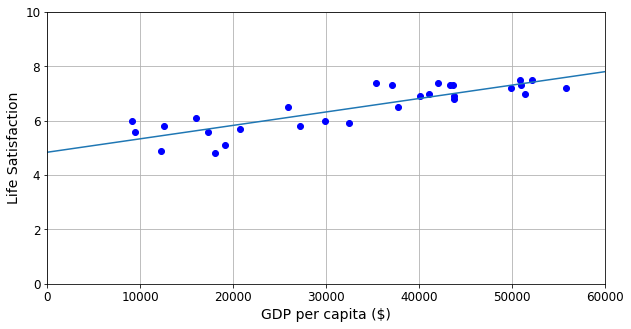

In [15]:
def plot_life_satisfaction_with_linear_model(X_train, y_train, w, b):
    plot_life_satisfaction(X_train, y_train)
    plt.plot([0, 60000], [b, w[0][0] * (60000 / 10000) + b])

plt.figure(figsize=(10, 5))
plot_life_satisfaction_with_linear_model(X_train, y_train, w_val, b_val)
plt.show()

Try not to peek at the solution below before you have done the exercise! :)

![thinking](https://upload.wikimedia.org/wikipedia/commons/0/06/Filos_segundo_logo_%28flipped%29.jpg)

## Exercise 4 - Solution

4.1)

In [16]:
graph = tf.Graph()
with graph.as_default():
    X = tf.constant(X_train, name="X")
    y = tf.constant(y_train, name="y")

    b = tf.Variable(0.0, name="b")
    w = tf.Variable(tf.zeros([1, 1]), name="w")
    y_pred = tf.add(tf.matmul(X, w), b, name="y_pred")  # X @ w + b
    
    init = tf.global_variables_initializer()

4.2)

In [17]:
with tf.Session(graph=graph) as sess:
    init.run()
    print(y_pred.eval())

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


4.3)

In [18]:
with graph.as_default():
    error = y_pred - y
    square_error = tf.square(error)
    mse = tf.reduce_mean(square_error, name="mse")

4.4)

In [19]:
with tf.Session(graph=graph) as sess:
    init.run()
    print(mse.eval())

42.841034


4.5)

In [20]:
with graph.as_default():
    m = len(X_train)
    gradients_w = 2/m * tf.matmul(tf.transpose(X), error)
    gradients_b = 2 * tf.reduce_mean(error)

4.6)

In [21]:
learning_rate = 0.01

with graph.as_default():
    tweak_w_op = tf.assign(w, w - learning_rate * gradients_w)
    tweak_b_op = tf.assign(b, b - learning_rate * gradients_b)
    training_op = tf.group(tweak_w_op, tweak_b_op)

4.7)

In [22]:
n_iterations = 2000

with tf.Session(graph=graph) as sess:
    init.run()
    for iteration in range(n_iterations):
        if iteration % 100 == 0:
            print("Iteration {:5}, MSE: {:.4f}".format(iteration, mse.eval()))
        training_op.run()
    w_val, b_val = sess.run([w, b])

Iteration     0, MSE: 42.8410
Iteration   100, MSE: 1.8935
Iteration   200, MSE: 1.1304
Iteration   300, MSE: 0.7073
Iteration   400, MSE: 0.4727
Iteration   500, MSE: 0.3426
Iteration   600, MSE: 0.2705
Iteration   700, MSE: 0.2305
Iteration   800, MSE: 0.2083
Iteration   900, MSE: 0.1960
Iteration  1000, MSE: 0.1892
Iteration  1100, MSE: 0.1855
Iteration  1200, MSE: 0.1834
Iteration  1300, MSE: 0.1822
Iteration  1400, MSE: 0.1816
Iteration  1500, MSE: 0.1812
Iteration  1600, MSE: 0.1810
Iteration  1700, MSE: 0.1809
Iteration  1800, MSE: 0.1808
Iteration  1900, MSE: 0.1808


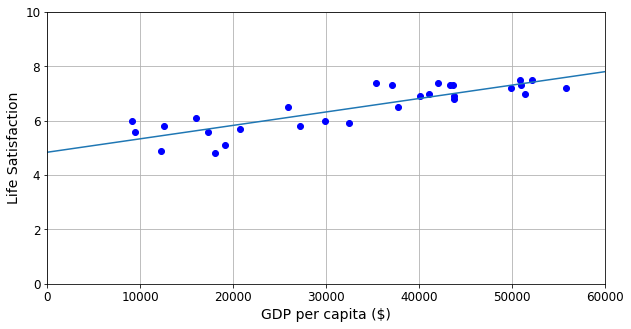

In [23]:
def plot_life_satisfaction_with_linear_model(X_train, y_train, w, b):
    plot_life_satisfaction(X_train, y_train)
    plt.plot([0, 60000], [b, w[0][0] * (60000 / 10000) + b])

plt.figure(figsize=(10, 5))
plot_life_satisfaction_with_linear_model(X_train, y_train, w_val, b_val)
plt.show()

In [24]:
import numpy as np
from IPython.display import display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, max_const_size=32):
    """Visualize TensorFlow graph."""
    graph_def = graph_def or tf.get_default_graph()
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [25]:
show_graph(graph)